In [ ]:
!pip install compress-fasttext > /dev/null

In [ ]:
!pip install sentence-transformers > /dev/null

In [ ]:
!gdown "13ZkrYeq_tZW_yTGzBYh-nHScsLk8nWa8"

Downloading...
From: https://drive.google.com/uc?id=13ZkrYeq_tZW_yTGzBYh-nHScsLk8nWa8
To: /content/train.csv
100% 29.8M/29.8M [00:00<00:00, 98.8MB/s]


In [ ]:
import nltk
import torch
import string
import numpy as np
import pandas as pd
import compress_fasttext
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from sentence_transformers import SentenceTransformer, InputExample, util

In [ ]:
from spp import tokenize, SentenceProcessingPipeline
from models import Rule, Levenshtein, Fasttext, Transformer
from utils import word_frequency, freq_to_set, clear, get_unique_values
from tools import compute_v2, validate_v2, benchmark_v2_core, benchmark_v2
from ranking_metrics import get_sims, get_relatives, precision_at_k, average_precision_at_k, mean_average_precision_at_k

In [ ]:
from gensim.models.fasttext import logger
logger.disabled = True

In [ ]:
nltk.download('punkt')
nltk.download("stopwords")
None

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0


In [ ]:
len(df)

497819

In [ ]:
df[df["is_duplicate"] == 0]

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0


In [ ]:
df[(df["is_duplicate"] == 1) & (df["name_1"] != df["name_2"])]

,pair_id,name_1,name_2,is_duplicate
161,162,JX Nippon Oil & Gas Exploration (Brasil) Ltda,JX Nippon Oil & Gas Exploration Technical Serv...,1
603,604,Pirelli Neumaticos S.A.I.C.,"Pirelli Tyre Co., Ltd.",1
835,836,Brenntag Australia (Pty) Ltd.,Brenntag Group,1
1328,1329,"PAUL BAUDER GMBH & CO KG, BOCHUM PLANT",Paul Bauder ag,1
1562,1563,TOTAL CESKA REPUBLIKA s.r.o.,TOTAL FRANCE (ARNAY LE DUC),1
...,...,...,...,...
496574,496575,"Bridgestone （Huizhou）Synthetic Rubber Co., Ltd.","Bridgestone India Pvt., Ltd.",1
496760,496761,Arlanxeo International Group,Arlanxeo Corp.,1
497015,497016,Brenntag Peru S.A.C.,Brenntag Chile Comercial E Industrial Ltda,1
497083,497084,Dow Chemical International Private Ltd.,Dow Chemical Pacific,1


In [ ]:
non_ascii = "[^\x00-\x7F]"
df[~(((df["name_1"].str.contains(non_ascii) | df["name_2"].str.contains(non_ascii))))]

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0


In [ ]:
df[df.isna().any(axis=1)]

,pair_id,name_1,name_2,is_duplicate


In [ ]:
df[df.isnull().any(axis=1)]

,pair_id,name_1,name_2,is_duplicate


In [ ]:
df[df["name_1"] == df["name_2"]]

,pair_id,name_1,name_2,is_duplicate
5117,5118,"ООО""ИМПОРТ МОДА""","ООО""ИМПОРТ МОДА""",1
12160,12161,"ООО""ГУЧЧИ РУС""","ООО""ГУЧЧИ РУС""",1
14857,14858,Lohmann GmbH & Co. KG,Lohmann GmbH & Co. KG,1
25949,25950,"ООО""ПРИВАТ ТРЭЙД""","ООО""ПРИВАТ ТРЭЙД""",1
38345,38346,"ООО""СПЕЦИАЛЬНОЕ ОБОРУДОВАНИЕ""","ООО""СПЕЦИАЛЬНОЕ ОБОРУДОВАНИЕ""",1
139209,139210,"ООО""ФАВОРИТ СТАЙЛ","ООО""ФАВОРИТ СТАЙЛ",1
150207,150208,"ООО""ОЗОН ГИЙИМ РСЙ""","ООО""ОЗОН ГИЙИМ РСЙ""",1
151690,151691,"ООО ""ХИММАРКЕТ""","ООО ""ХИММАРКЕТ""",1
169770,169771,"ООО""ВЕРТИКАЛЬ СПОРТ""","ООО""ВЕРТИКАЛЬ СПОРТ""",1
226434,226435,"ООО ""СТАРКОМ""","ООО ""СТАРКОМ""",1


In [ ]:
df[df["name_1"].str.lower() == df["name_2"].str.lower()]

,pair_id,name_1,name_2,is_duplicate
5117,5118,"ООО""ИМПОРТ МОДА""","ООО""ИМПОРТ МОДА""",1
12160,12161,"ООО""ГУЧЧИ РУС""","ООО""ГУЧЧИ РУС""",1
14857,14858,Lohmann GmbH & Co. KG,Lohmann GmbH & Co. KG,1
25949,25950,"ООО""ПРИВАТ ТРЭЙД""","ООО""ПРИВАТ ТРЭЙД""",1
38345,38346,"ООО""СПЕЦИАЛЬНОЕ ОБОРУДОВАНИЕ""","ООО""СПЕЦИАЛЬНОЕ ОБОРУДОВАНИЕ""",1
139209,139210,"ООО""ФАВОРИТ СТАЙЛ","ООО""ФАВОРИТ СТАЙЛ",1
150207,150208,"ООО""ОЗОН ГИЙИМ РСЙ""","ООО""ОЗОН ГИЙИМ РСЙ""",1
151690,151691,"ООО ""ХИММАРКЕТ""","ООО ""ХИММАРКЕТ""",1
169770,169771,"ООО""ВЕРТИКАЛЬ СПОРТ""","ООО""ВЕРТИКАЛЬ СПОРТ""",1
226434,226435,"ООО ""СТАРКОМ""","ООО ""СТАРКОМ""",1


In [ ]:
df[(df["is_duplicate"] == 1) & df["name_1"].str.contains('"')]

,pair_id,name_1,name_2,is_duplicate
5117,5118,"ООО""ИМПОРТ МОДА""","ООО""ИМПОРТ МОДА""",1
12160,12161,"ООО""ГУЧЧИ РУС""","ООО""ГУЧЧИ РУС""",1
25949,25950,"ООО""ПРИВАТ ТРЭЙД""","ООО""ПРИВАТ ТРЭЙД""",1
38345,38346,"ООО""СПЕЦИАЛЬНОЕ ОБОРУДОВАНИЕ""","ООО""СПЕЦИАЛЬНОЕ ОБОРУДОВАНИЕ""",1
71617,71618,"ООО""ЭССИЭЙ ХАЙДЖИН ПРОДАКТС РАША СВЕТОГОРСКИЙ ...","ООО""ЭССИЭЙ ХАЙДЖИН ПРОДАКТС РАША""",1
90514,90515,"K-FLEX POLSKA SP. Z.O.O.""","ООО ""К-ФЛЕКС""",1
139209,139210,"ООО""ФАВОРИТ СТАЙЛ","ООО""ФАВОРИТ СТАЙЛ",1
150207,150208,"ООО""ОЗОН ГИЙИМ РСЙ""","ООО""ОЗОН ГИЙИМ РСЙ""",1
151690,151691,"ООО ""ХИММАРКЕТ""","ООО ""ХИММАРКЕТ""",1
169770,169771,"ООО""ВЕРТИКАЛЬ СПОРТ""","ООО""ВЕРТИКАЛЬ СПОРТ""",1


In [ ]:
ps = PorterStemmer()
tokenizer = wordpunct_tokenize
trans = str.maketrans("", "", string.punctuation)
stop_words = set(stopwords.words())
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
tokenizer("Xeikon Industrial Co., Ltd. Of Dongguan City")

['Xeikon', 'Industrial', 'Co', '.,', 'Ltd', '.', 'Of', 'Dongguan', 'City']

In [ ]:
tokenizer('ООО"ГЭЛАКСИ КАРГО СЕРВИС"')

['ООО', '"', 'ГЭЛАКСИ', 'КАРГО', 'СЕРВИС', '"']

In [ ]:
ps.stem("Industries")

'industri'

In [ ]:
ps.stem("Industrial")

'industri'

In [ ]:
dfc = clear(df)

In [ ]:
dfct = tokenize(dfc, 250)
dfct

,pair_id,name_1,name_2,is_duplicate,name_1_tokens,name_2_tokens
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0,"(Iko,)","(Enormous,)"
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0,"(Apcotex,)","(Technocraft,)"
4,5,Tress A/S,Longyou Industries Park Zhejiang,0,"(Tress, AS)","(Longyou, Park)"
5,6,Wpt Mexico Sa De Cv,Hopkins Mfg. De Mexico S De Rl De Cv,0,"(Wpt,)","(Hopkins,)"
7,8,Citibank Korea Inc.,Kyor,0,"(Citibank, Korea)","(Kyor,)"
...,...,...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0,"(BITMAT, PRODUCTS)","(Goodyear, Company)"
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0,"(Bnd,)","(Zhong, Shan, Yue, Liang, Economy)"
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0,"(Xeikon,)","(Yi, Cheng)"
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0,"(Kechuan,)","(MG, Stationery)"


In [ ]:
fasttext_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load(
    'https://github.com/avidale/compress-fasttext/releases/download/gensim-4-draft/ft_cc.en.300_freqprune_400K_100K_pq_300.bin'
)

In [ ]:
fasttext = Fasttext(fasttext_model)
res, _ = compute_v2(dfct, fasttext)
res

/usr/local/lib/python3.7/dist-packages/gensim/models/fasttext.py:1128: RuntimeWarning: invalid value encountered in true_divide
  return word_vec / np.linalg.norm(word_vec)


,pair_id,name_1,name_2,is_duplicate,name_1_tokens,name_2_tokens,names_sim
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0,"(Iko,)","(Enormous,)",0.068913
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0,"(Apcotex,)","(Technocraft,)",0.456489
4,5,Tress A/S,Longyou Industries Park Zhejiang,0,"(Tress, AS)","(Longyou, Park)",0.329134
7,8,Citibank Korea Inc.,Kyor,0,"(Citibank, Korea)","(Kyor,)",0.110140
8,9,Prettl Electric Del Bajio S.A. De C.V.,Bva Inc.,0,"(Prettl, Electric, Bajio)","(Bva,)",0.305529
...,...,...,...,...,...,...,...
497812,497813,Highline General Trading Co.,D Donato Trading Srl .,0,"(Highline,)","(Donato,)",0.037857
497813,497814,Trinseo API,BATEC GROUP GmbH,0,"(Trinseo, API)","(BATEC, GROUP)",0.398726
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0,"(BITMAT, PRODUCTS)","(Goodyear, Company)",0.099312
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0,"(Xeikon,)","(Yi, Cheng)",0.027852


In [ ]:
rule = Rule()
res, _ = compute_v2(dfct, rule)
res

,pair_id,name_1,name_2,is_duplicate,name_1_tokens,name_2_tokens,names_sim
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0,"(Iko,)","(Enormous,)",0.0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0,"(Apcotex,)","(Technocraft,)",0.0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0,"(Tress, AS)","(Longyou, Park)",0.0
5,6,Wpt Mexico Sa De Cv,Hopkins Mfg. De Mexico S De Rl De Cv,0,"(Wpt,)","(Hopkins,)",0.0
7,8,Citibank Korea Inc.,Kyor,0,"(Citibank, Korea)","(Kyor,)",0.0
...,...,...,...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0,"(BITMAT, PRODUCTS)","(Goodyear, Company)",0.0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0,"(Bnd,)","(Zhong, Shan, Yue, Liang, Economy)",0.0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0,"(Xeikon,)","(Yi, Cheng)",0.0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0,"(Kechuan,)","(MG, Stationery)",0.0


In [ ]:
liv = Levenshtein()
res, _ = compute_v2(dfct, liv)
res

,pair_id,name_1,name_2,is_duplicate,name_1_tokens,name_2_tokens,names_sim
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0,"(Iko,)","(Enormous,)",0.0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0,"(Apcotex,)","(Technocraft,)",0.0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0,"(Tress, AS)","(Longyou, Park)",0.0
5,6,Wpt Mexico Sa De Cv,Hopkins Mfg. De Mexico S De Rl De Cv,0,"(Wpt,)","(Hopkins,)",0.0
7,8,Citibank Korea Inc.,Kyor,0,"(Citibank, Korea)","(Kyor,)",0.0
...,...,...,...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0,"(BITMAT, PRODUCTS)","(Goodyear, Company)",0.0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0,"(Bnd,)","(Zhong, Shan, Yue, Liang, Economy)",0.0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0,"(Xeikon,)","(Yi, Cheng)",0.0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0,"(Kechuan,)","(MG, Stationery)",0.0


Max f-score: 0.34061267819229607
Accuracy   : 0.9851340770853492
Precision  : 0.2594731977818854
Recall     : 0.49558693733451015
Performance: 16.191591926


/usr/local/lib/python3.7/dist-packages/gensim/models/fasttext.py:1128: RuntimeWarning: invalid value encountered in true_divide
  return word_vec / np.linalg.norm(word_vec)


Max f-score: 0.40907918493680684
Accuracy   : 0.9916456684012267
Precision  : 0.46293053123175715
Recall     : 0.3664510166358595
Performance: 15.097134315000005


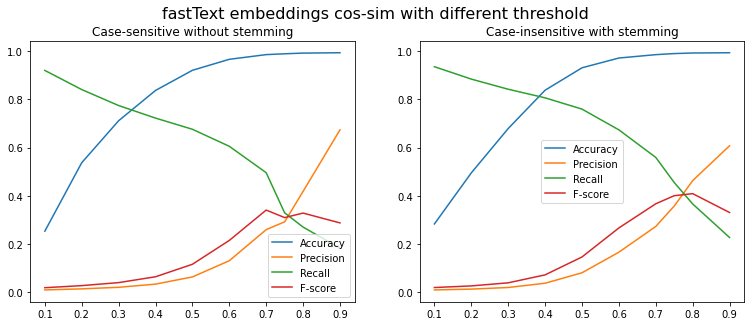

In [ ]:
benchmark_v2(dfc, fasttext, 250, "fastText embeddings cos-sim with different threshold")

Max f-score: 0.3168693009118541
Accuracy   : 0.9858192573118633
Precision  : 0.23928844682478959
Recall     : 0.4688905547226387
Performance: 6.417618012999981
Max f-score: 0.35402906208718626
Accuracy   : 0.9930986400510333
Precision  : 0.5398871877518131
Recall     : 0.26336477987421386
Performance: 4.957121529999995


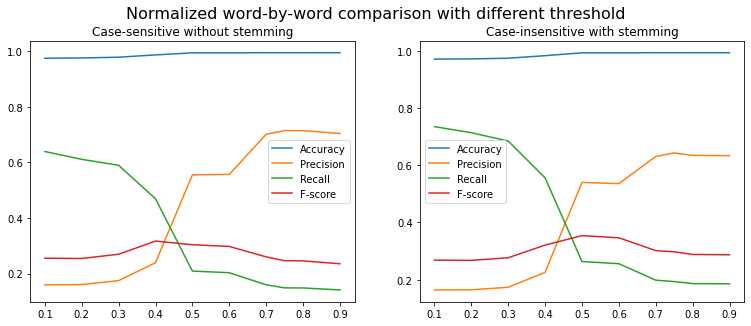

In [ ]:
benchmark_v2(dfc, rule, 250, "Normalized word-by-word comparison with different threshold")

Max f-score: 0.3225128137731634
Accuracy   : 0.9864475846204404
Precision  : 0.24833029751062538
Recall     : 0.4598950524737631
Performance: 6.916611504000002
Max f-score: 0.3499866417312317
Accuracy   : 0.9931325117563043
Precision  : 0.5462885738115096
Recall     : 0.2574685534591195
Performance: 6.429234963999988


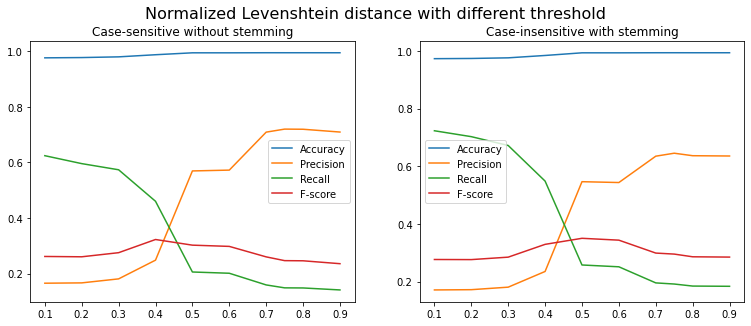

In [ ]:
benchmark_v2(dfc, liv, 250, "Normalized Levenshtein distance with different threshold")

In [ ]:
res[(res["is_duplicate"] == 1) & (res["names_sim"] > 0.7)]

,pair_id,name_1,name_2,is_duplicate,name_1_tokens,name_2_tokens,names_sim
161,162,JX Nippon Oil & Gas Exploration (Brasil) Ltda,JX Nippon Oil & Gas Exploration Technical Serv...,1,"(JX, Nippon, Oil, Gas, Exploration)","(JX, Nippon, Oil, Gas, Exploration, Technical)",0.833333
3276,3277,JX Nippon Oil & Gas Exploration (Brasil) Ltda,"JX Nippon Oil & Gas Exploration (Sarawak), Ltd",1,"(JX, Nippon, Oil, Gas, Exploration)","(JX, Nippon, Oil, Gas, Exploration, Sarawak)",0.833333
3842,3843,Dow Chemical,Dow Chemical Pacific,1,"(Dow,)","(Dow,)",1.000000
4145,4146,Toyo Trans Inc.,Toyo Tire North,1,"(Toyo,)","(Toyo,)",1.000000
5117,5118,"ООО""ИМПОРТ МОДА""","ООО""ИМПОРТ МОДА""",1,"(ОООИМПОРТ, МОДА)","(ОООИМПОРТ, МОДА)",1.000000
...,...,...,...,...,...,...,...
488736,488737,"ООО""НОВЫЙ МИР""","ООО""НОВЫЙ МИР""",1,"(ОООНОВЫЙ, МИР)","(ОООНОВЫЙ, МИР)",1.000000
489388,489389,Sika Sa,Sika S A.,1,"(Sika,)","(Sika,)",1.000000
494851,494852,Kuraray India Private Ltd.,Kuraray America Inc.,1,"(Kuraray,)","(Kuraray,)",1.000000
496760,496761,Arlanxeo International Group,Arlanxeo Corp.,1,"(Arlanxeo,)","(Arlanxeo,)",1.000000


In [ ]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
emb1 = sbert.encode("JX Nippon Oil & Gas Exploration (Brasil) Ltda")
emb2 = sbert.encode("JX Nippon Oil & Gas Exploration (Sarawak), Ltd")

In [ ]:
util.cos_sim(emb1, emb2)

tensor([[0.8110]])

In [ ]:
np.dot(emb1, emb2)

0.81096995

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
sbert = Transformer(sbert_model)
res, _ = compute_v2(dfct, sbert)
res

,pair_id,name_1,name_2,is_duplicate,name_1_tokens,name_2_tokens,names_sim
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0,"(Iko,)","(Enormous,)",0.197920
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0,"(Apcotex,)","(Technocraft,)",0.283467
4,5,Tress A/S,Longyou Industries Park Zhejiang,0,"(Tress, AS)","(Longyou, Park)",0.242203
5,6,Wpt Mexico Sa De Cv,Hopkins Mfg. De Mexico S De Rl De Cv,0,"(Wpt,)","(Hopkins,)",0.194845
7,8,Citibank Korea Inc.,Kyor,0,"(Citibank, Korea)","(Kyor,)",0.218890
...,...,...,...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0,"(BITMAT, PRODUCTS)","(Goodyear, Company)",0.199131
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0,"(Bnd,)","(Zhong, Shan, Yue, Liang, Economy)",0.198411
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0,"(Xeikon,)","(Yi, Cheng)",0.323566
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0,"(Kechuan,)","(MG, Stationery)",0.069815


In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9]

Max f-score: 0.23538683830290294
Accuracy   : 0.9880824910275755
Precision  : 0.22631977772164688
Recall     : 0.24521072796934865
Performance: 14.900189252000018


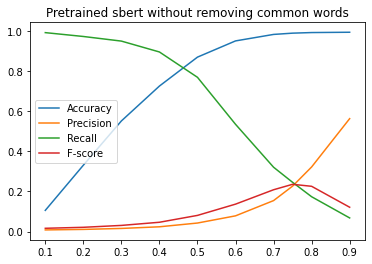

In [ ]:
benchmark_v2_core(dfc, sbert, 0, thresholds, case=False, title="Pretrained sbert without removing common words")

Max f-score: 0.22964840038010767
Accuracy   : 0.9902293805579939
Precision  : 0.2729668674698795
Recall     : 0.1981957353745216
Performance: 15.204679578000082
Max f-score: 0.18659087109179068
Accuracy   : 0.9900254438318697
Precision  : 0.23969072164948454
Recall     : 0.15275116342732
Performance: 15.695551844999954


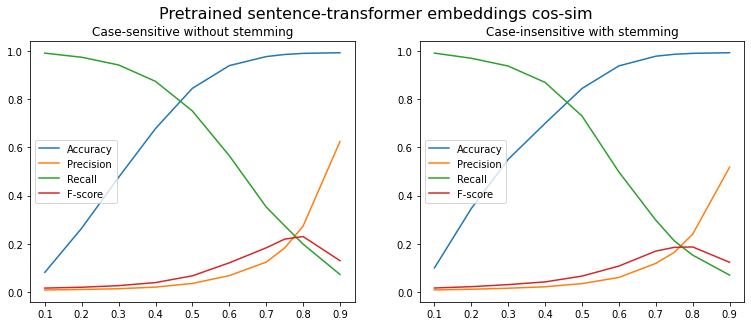

In [ ]:
benchmark_v2(dfc, sbert, 0, "Pretrained sentence-transformer embeddings cos-sim")

Max f-score: 0.424680377987771
Accuracy   : 0.9918370029576076
Precision  : 0.41993404177354343
Recall     : 0.4295352323838081
Performance: 12.255374033000066
Max f-score: 0.39252662825213896
Accuracy   : 0.9901800281135154
Precision  : 0.35312598177819665
Recall     : 0.4418238993710692
Performance: 10.618200278000018


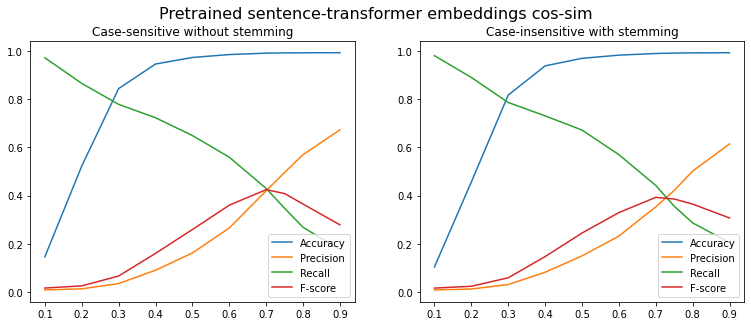

In [ ]:
benchmark_v2(dfc, sbert, 250, "Pretrained sentence-transformer embeddings cos-sim")

Max f-score: 0.4459683140222275
Accuracy   : 0.9925212583948316
Precision  : 0.42230183609493954
Recall     : 0.4724448897795591
Performance: 10.14413227099999


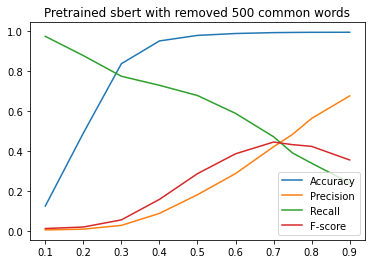

In [ ]:
benchmark_v2_core(dfc, sbert, 500, thresholds, title="Pretrained sbert with removed 500 common words")

In [ ]:
benchmark_v2_core(dfc, sbert, 1000, thresholds, title="Pretrained sbert with removed 1000 common words")

In [ ]:
dfc

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0


In [ ]:
def class_distributions_plot(dfc):
    res = dfc["is_duplicate"].value_counts()
    x = res.index.to_list()
    y = res.to_numpy()
    plt.bar(x, y)
    return y / len(dfc)

array([0.99299234, 0.00700766])

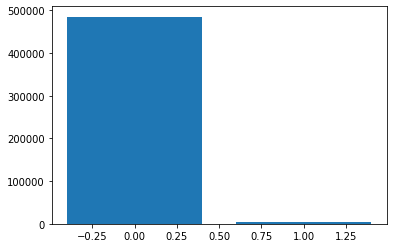

In [ ]:
class_distributions_plot(dfc)

In [ ]:
idx = 161
n1, n2 = dfct.loc[idx]["name_1_tokens"], dfct.loc[idx]["name_2_tokens"]
n1, n2, rule.calc(n1, n2)

(('JX', 'Nippon', 'Oil', 'Gas', 'Exploration'),
 ('JX', 'Nippon', 'Oil', 'Gas', 'Exploration', 'Technical'),
 0.8333333333333334)

In [ ]:
liv = Levenshtein()
a = "The patient tolerated this ."
b = "The patient tolerated ."
a = tuple(a.split(" "))
b = tuple(b.split(" "))
liv.calc(a, b)

0.8

In [ ]:
len(stopwords.words()), len(set(stopwords.words()))

(10405, 9380)

In [ ]:
spp = SentenceProcessingPipeline()
spp("My boba is aboba. (cringe)")

('My', 'boba', 'aboba', 'cringe')

In [ ]:
spp = SentenceProcessingPipeline(stemming=True)
spp("Stemming increases recall while harming precision")

('stem', 'increas', 'recal', 'harm', 'precis')

In [ ]:
dfc

,pair_id,name_1,name_2,is_duplicate
0,1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
1,2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
2,3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
3,4,Powermax Rubber Factory,Co. One,0
4,5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...,...
497814,497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497815,497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497816,497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0
497817,497818,"Shanghai Kechuan Trading Co., Ltd.",Shanghai M&G Stationery Inc.,0


In [ ]:
dfc[(dfc["name_1"] == "Basf Finlay Pvt., Ltd.") & (dfc["is_duplicate"] == 1 )]

,pair_id,name_1,name_2,is_duplicate
12124,12125,"Basf Finlay Pvt., Ltd.",Basf India Ltd.,1
12294,12295,"Basf Finlay Pvt., Ltd.","Basf Co., Ltd.",1
48007,48008,"Basf Finlay Pvt., Ltd.",Basf Corporation,1
75614,75615,"Basf Finlay Pvt., Ltd.",Basf Bangladesh Ltd.,1
97978,97979,"Basf Finlay Pvt., Ltd.",Basf Chile S.A.,1
115028,115029,"Basf Finlay Pvt., Ltd.",Basf Corp.,1
158466,158467,"Basf Finlay Pvt., Ltd.",Basf Chile S A,1
286455,286456,"Basf Finlay Pvt., Ltd.",Basf India,1
324450,324451,"Basf Finlay Pvt., Ltd.","Basf (China) Co., Ltd. Shanghai",1
472354,472355,"Basf Finlay Pvt., Ltd.",Basf Sa,1


In [ ]:
spp = SentenceProcessingPipeline(remove_punkt=False, default_stopwords=False)
tokens = spp("Basf Finlay Pvt., Ltd.")
tokens

('Basf', 'Finlay', 'Pvt.,', 'Ltd.')

In [ ]:
vector = sbert.encode(tokens)
vector.shape

(384,)

In [ ]:
names_unique = get_unique_values(dfc, names=["name_1", "name_2"])
len(names_unique)

17676

In [ ]:
s2v = {name:sbert.encode(spp(name)) for name in names_unique}

In [ ]:
dfn = pd.DataFrame(data={"vector":s2v})
dfn

,vector
Alfagomma,"[-0.06237692, 0.058182895, -0.0012199932, 0.04..."
CONTITECH TRANSPORTBANDSYSTEME GMBH,"[-0.04375706, 0.008371607, -0.059462577, -0.05..."
LANXESS Inc.,"[-0.06310115, -0.007947164, 0.037389286, -0.02..."
Lanxess AG,"[-0.069392435, -0.013326999, 0.038561277, -0.0..."
Lanxess Accounting GmbH,"[-0.028719397, 0.00028546553, 0.021133354, -0...."
...,...
pirelli tyre russia,"[-0.052812994, 0.0078233695, -0.0815616, -0.01..."
porr ag,"[-0.09994296, 0.01018365, 0.0036624009, -0.018..."
soprema Soprema sas,"[-0.005006347, 0.07529626, -0.08272261, 0.0049..."
swisspor ag,"[-0.08029956, 0.029784882, -0.031132217, 0.010..."


In [ ]:
def get_sims(dfn, name):
    vector = s2v[name]
    sims = dfn["vector"].apply(lambda x: np.dot(x, vector))
    return sims

In [ ]:
name = "Basf Finlay Pvt., Ltd."

In [ ]:
sims = get_sims(dfn, s2v, name)
sims

 Alfagomma                              0.073042
 CONTITECH TRANSPORTBANDSYSTEME GMBH    0.325193
 LANXESS Inc.                           0.385777
 Lanxess AG                             0.278659
 Lanxess Accounting GmbH                0.416448
                                          ...   
pirelli tyre russia                     0.252420
porr ag                                 0.260042
soprema Soprema sas                     0.229193
swisspor ag                             0.449539
tsrc                                    0.252476
Name: vector, Length: 17676, dtype: float32

In [ ]:
relatives = get_relatives(dfc, name)
relatives

{'Basf (China) Co., Ltd. Shanghai',
 'Basf Bangladesh Ltd.',
 'Basf Chile S A',
 'Basf Chile S.A.',
 'Basf Co., Ltd.',
 'Basf Corp.',
 'Basf Corporation',
 'Basf India',
 'Basf India Ltd.',
 'Basf Sa'}

In [ ]:
precision = precision_at_k(sims, relatives)
precision

0.4

In [ ]:
average_precision = average_precision_at_k(sims, relatives)
average_precision

0.5833333333333333

In [ ]:
mAP = mean_average_precision_at_k(dfc, dfn)
mAP

17676/17676


0.022805247542178973

In [ ]:
dfcd = dfc[dfc["is_duplicate"] == 1]
names_unique_d = get_unique_values(dfcd, names=["name_1", "name_2"])
s2vd = {name:sbert.encode(spp(name)) for name in names_unique}
dfnd = pd.DataFrame(data={"vector":s2vd})

In [ ]:
mAPd = mean_average_precision_at_k(dfcd, dfnd)
mAPd

1101/1101


0.36612675345645357